In [1]:
%load_ext autoreload
%autoreload 2

In [99]:
import numpy as np
%matplotlib widget
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.linalg as la
import pyvista as pv
import pathlib
import imageio.v3 as iio
import os
import seaborn as sns
np.set_printoptions(formatter={"float": "{:10.2f}".format})
scene_names = ["2018-07-21","2018-07-25","2018-07-28","2018-08-14", "2018-08-17","2018-08-18","2018-08-19"]

In [8]:
from src.experiment import Experiment
mesh_path = "C:/Users/Julian/Nextcloud/Uni/Semester 8/ushichka-registration/data/formatted/lidar_roi.ply"
#mesh_path = "/home/julian/code/uni/ushichka-registration/data/formatted/lidar_roi.ply"
#exp_dirs = list(pathlib.Path("/home/julian/data/dmcp_experiments/round_05").glob("2018*"))
exp_dirs = list(pathlib.Path("/data/dmcp_experiments/round_05").glob("2018*"))
exps = [Experiment(str(exp_dir),mesh_path) for exp_dir in exp_dirs]

In [9]:
repr_errs = []
for exp in exps:
    repr_file = list(pathlib.Path(exp.exp_dir).glob("reprErrs*"))[0]
    reprs = np.loadtxt(repr_file)
    repr_errs.append(reprs)
idxs = list(range(len(repr_errs)))

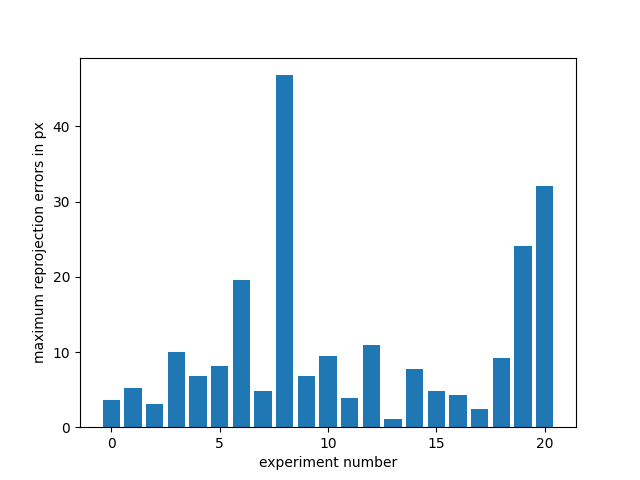

In [10]:
max_repr_errs = [np.max(re)  for re in repr_errs]
plt.figure()
plt.bar(idxs,max_repr_errs)
plt.ylabel("maximum reprojection errors in px")
plt.xlabel("experiment number")
plt.show()

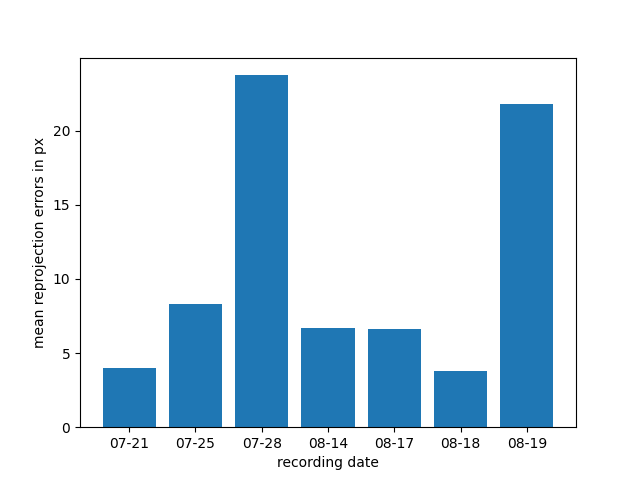

In [14]:
combined_errrs = [ np.mean((max_repr_errs[i],max_repr_errs[i+1],max_repr_errs[i+2])) for i in range(0,len(max_repr_errs),3)]
plt.figure()
plt.bar(scene_names,combined_errrs)
plt.ylabel("mean reprojection errors in px")
plt.xlabel("recording date")
#plt.savefig("/home/julian/Downloads/ushichka_experiment_reprojection_errs.eps")
plt.show()

In [213]:
# TODO Quality analysis similar to experiment_variation
def pinhole_pose(P):
    pose_hat = la.null_space(P) / la.null_space(P)[-1]
    return pose_hat[:3].flatten()

transformed_scenes = []
for i in range(0,len(exps),3):
    exp0 = exps[i]
    exp1 = exps[i+1]
    exp2 = exps[i+2]
    
    Ps_native = [exp0.load_imP(), exp1.load_imP(), exp2.load_imP()]
    transforms = [exp0.load_transform(), exp1.load_transform(), exp2.load_transform()]
    transformed_cameras = []
    for P_native in Ps_native:
        estimated_positions = []
        for trans in transforms:
            P_world = P_native @ la.inv(trans)
            poss_world = pinhole_pose(P_world)
            estimated_positions.append(poss_world)
        transformed_cameras.append(estimated_positions)
    transformed_scenes.append(transformed_cameras)
len(transformed_scenes)

[[array([      0.48,       2.65,       0.95]),
  array([      0.24,       3.30,       0.91]),
  array([      0.13,       3.42,       0.87])],
 [array([      0.60,      -1.01,      -1.43]),
  array([      0.65,      -0.33,      -1.47]),
  array([      0.57,      -0.04,      -1.74])],
 [array([     -0.49,      -2.27,      -0.34]),
  array([     -0.33,      -1.67,      -0.39]),
  array([     -0.33,      -1.48,      -0.72])]]

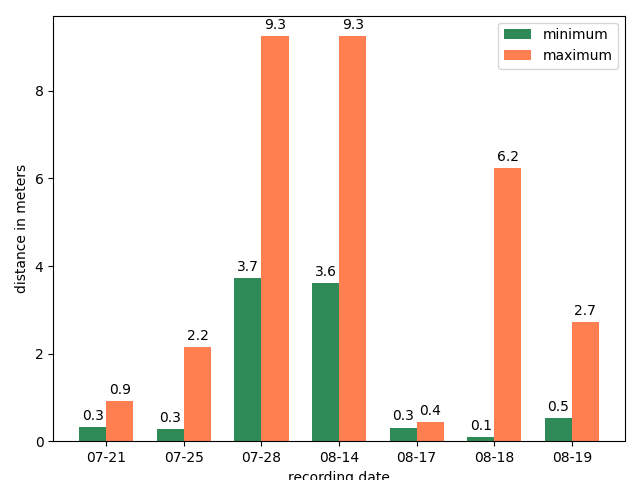

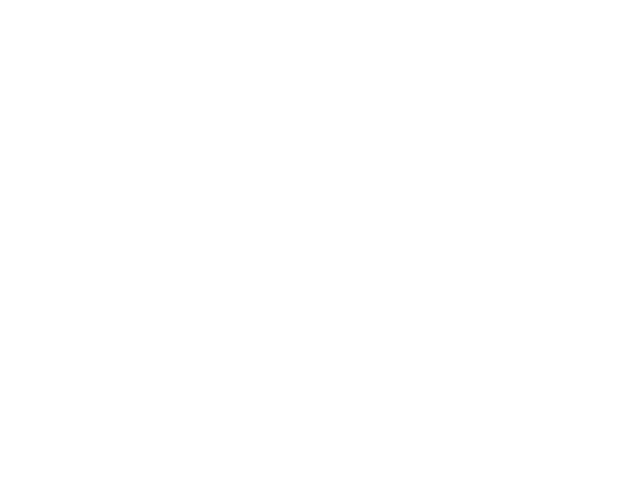

In [26]:
from itertools import combinations
def dists(points):
    dists = []
    for comb in combinations(points,2):
        p1, p2 = comb
        dist = la.norm(abs(p1 - p2))
        dists.append(dist)
    return dists

mean_min_dists = []
mean_max_dists = []
for scene in transformed_scenes:
    min_dist = [np.mean(min(dists(camera))) for camera in scene]
    mean_min_dists.append(np.mean(min_dist))
    max_dist = [np.mean(max(dists(camera))) for camera in scene]
    mean_max_dists.append(np.mean(max_dist))

x = np.arange(len(scene_names))  # the label locations
width = 0.35  # the width of the bars

plt.figure()
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, mean_min_dists, width, label='minimum',color="seagreen")
rects2 = ax.bar(x + width/2, mean_max_dists, width, label='maximum',color="coral")

ax.set_ylabel('distance in meters')
#ax.set_title('m')
ax.set_xticks(x, scene_names)
ax.legend()

ax.bar_label(rects1,np.round(mean_min_dists,1), padding=3)
ax.bar_label(rects2, np.round(mean_max_dists,1) ,padding=3)

fig.tight_layout()

#plt.ylabel("mean reprojection errors in px")
plt.xlabel("recording date")
#plt.savefig("/home/julian/Downloads/ushichka_experiment_camera_distances.eps")

plt.show()

In [87]:
import pandas as pd
data = pd.DataFrame(repr_errs)
#data.rename(columns={0:"max_repr_errs"}, inplace=True)
#data = data.melt()
data = data.transpose()
data

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,4.8,0.00,0.00,...,0.00,0.00,0.00,7.77,0.0,4.26,0.00,0.00,0.00,0.00
1,3.62,5.17,0.00,9.94,0.0,0.00,19.61,0.0,46.81,6.76,...,0.00,10.95,0.00,0.00,0.0,0.00,0.00,0.00,24.13,32.13
2,0.00,0.00,3.12,0.00,6.8,8.17,0.00,0.0,0.00,0.00,...,0.00,0.00,0.00,0.00,4.8,0.00,2.36,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,...,3.85,0.00,1.12,0.00,0.0,0.00,0.00,9.16,0.00,0.00


In [208]:
print(scene[0])
dists(scene[0])

[array([     -1.83,       4.34,       0.03]), array([     -0.18,       2.47,       0.01]), array([     -0.52,       2.74,       0.00])]
(array([     -1.83,       4.34,       0.03]), array([     -0.18,       2.47,       0.01]))
(array([     -1.83,       4.34,       0.03]), array([     -0.52,       2.74,       0.00]))
(array([     -0.18,       2.47,       0.01]), array([     -0.52,       2.74,       0.00]))


[2.496347351762519, 2.0661088175336544, 0.43842649401347905]

In [241]:
def dists(points):
    dists = []
    for comb in combinations(points,2):
        p1, p2 = comb
        dist = la.norm(abs(p1 - p2))
        dists.append(dist)
    return dists
def flatten(t):
    return [item for sublist in t for item in sublist]
camera_dists = []
for scene in transformed_scenes:
    for camera in scene:
        ds = dists(camera)
        camera_dists.append(ds)
#camera_dists = pd.DataFrame(np.array(camera_dists))
#camera_dists
camera_dists = np.array(camera_dists)
mean_dists = np.mean(camera_dists,axis=1)

asdf
comb [      0.48       2.65       0.95] [      0.24       3.30       0.91]


comb [      0.48       2.65       0.95] [      0.13       3.42       0.87]


comb [      0.24       3.30       0.91] [      0.13       3.42       0.87]


asdf
comb [      0.60      -1.01      -1.43] [      0.65      -0.33      -1.47]


comb [      0.60      -1.01      -1.43] [      0.57      -0.04      -1.74]


comb [      0.65      -0.33      -1.47] [      0.57      -0.04      -1.74]


asdf
comb [     -0.49      -2.27      -0.34] [     -0.33      -1.67      -0.39]


comb [     -0.49      -2.27      -0.34] [     -0.33      -1.48      -0.72]


comb [     -0.33      -1.67      -0.39] [     -0.33      -1.48      -0.72]


asdf
comb [     -0.36       2.09       0.81] [      0.36       3.26       0.26]


comb [     -0.36       2.09       0.81] [      0.35       3.47       0.16]


comb [      0.36       3.26       0.26] [      0.35       3.47       0.16]


asdf
comb [      1.67      -1.42      -0.60] [      2.78

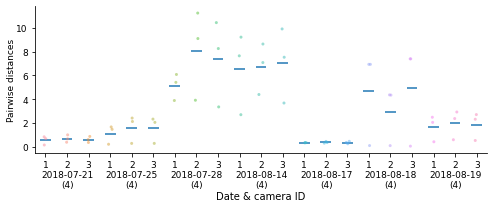

In [246]:
data = camera_dists.T
hlines = mean_dists
%matplotlib inline
plt.figure(figsize=(7,3))
#fig, ax = plt.subplots()
sns.stripplot(data=data,  edgecolor='none', jitter=True,
              alpha=0.5, size=3)

plt.xticks(range(21),['1','2','3']*7, fontsize=9); plt.xlim(-0.5,20.5)
plt.yticks(#ticks=[0, 10, 20, 30,40,50],
           fontsize=9)

plt.xlabel('Date & camera ID', labelpad=22)
plt.ylabel('Pairwise distances', fontsize=9, labelpad=0);

for i,med in enumerate(hlines):
    plt.hlines(med, i-0.25, i+0.25)
sns.despine();# plt.yscale('log')
date_x = np.arange(-0.2, 21, 3)
import matplotlib.transforms as transforms
trans = transforms.blended_transform_factory(plt.gca().transData, plt.gca().transAxes)
for x, night in zip(date_x, scene_names):
    plt.text(x, -.235, night+f'\n(4)', fontsize=9,
             multialignment='center',transform= trans)
plt.tight_layout()
#plt.savefig('preicp_meshdistances.png')
plt.show()